## Intro to ML and ML

- Machine learning (ML) and deep learning (DL) are both forms of **artificial intelligence (AI)**.
- AI arose in the 1950s and 60s to simulate human judgement.

![ELIZA](img/eliza.jpeg)

## AI Overview

- AI is about building programs that can make decisions like a human.
- You'll hear a lot of hype about AI, but it's just code and data!  There's no magic.

In [109]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-560m")
model = AutoModelForCausalLM.from_pretrained("bigscience/bloomz-560m")

prompt = "Explain what AI is. Explanation:"
inputs = tokenizer.encode(prompt, return_tensors="pt")
output = tokenizer.decode(model.generate(inputs, max_new_tokens=128)[0])
print(output.replace(prompt, ""))

 AI is a computer program that processes data and makes decisions based on that data.</s>


## Human Predictions

- Let's say we want to predict tomorrow's temperature
- We might look outside, and decide that tomorrow will be the same temperature as today

In [119]:
import pandas as pd
pd.read_csv("observations.csv", index_col=0)

,tmax,prediction
2022-11-20,61.0,61.0
2022-11-21,60.0,60.0
2022-11-22,62.0,62.0
2022-11-23,67.0,67.0
2022-11-24,66.0,66.0
2022-11-25,70.0,70.0
2022-11-26,62.0,62.0


## Testing Predictions

- Now, we want to know how good our predictions are
- We calculate the error of our predictions by taking the difference from the actuals

In [131]:
observations["error"] = (observations["tmax_tomorrow"] - observations["prediction"]).abs()
observations

,tmax,prediction,tmax_tomorrow,error
2022-11-20,61.0,61.0,60.0,1.0
2022-11-21,60.0,60.0,62.0,2.0
2022-11-22,62.0,62.0,67.0,5.0
2022-11-23,67.0,67.0,66.0,1.0
2022-11-24,66.0,66.0,70.0,4.0
2022-11-25,70.0,70.0,62.0,8.0
2022-11-26,62.0,62.0,64.0,2.0


## Error Metric

- It can be hard to interpret several individual error metrics
- We usually average the errors to create a single error number
- This metric is called mean absolute error, and we want it to be as low as possible

In [121]:
observations["error"].mean()

3.2857142857142856

## Expert Systems

- Computers run human-generated rules to make predictions
- Temperature rules
    - Tomorrow's temperature will be the average of the last 5 days
    - If today is more than 5 degrees warmer then yesterday, add 2 to tomorrow's temperature

In [122]:
expert = pd.read_csv("expert_error.csv", index_col=0)
expert["error"].mean()

3.057142857142857

## Machine Learning

- An algorithm automatically makes the rules for predictions
- Much less effort than expert systems

![tree](img/tree.svg)

## Linear Regression

- Learn a linear relationship between predictors $x$ and targets $y$
- Equation is $y=mx+b$.  The model learns $m$ and $b$ automatically using either an equation or gradient descent.

<AxesSubplot: xlabel='tmax', ylabel='tmax_tomorrow'>

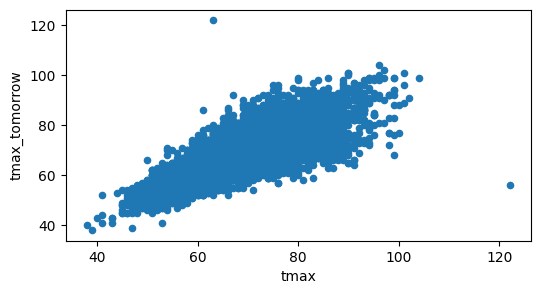

In [138]:
weather = pd.read_csv("clean_weather.csv", index_col=0)

weather.plot.scatter("tmax", "tmax_tomorrow", figsize=(6,3))

In [124]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
train = weather[:"2022-11-20"]

lr.fit(train[["tmax"]], train["tmax_tomorrow"])

LinearRegression()

In [125]:
test = weather["2022-11-20":]
preds = lr.predict(test[["tmax"]])

preds

array([61.91743649, 61.09882817, 62.73604481, 66.8290864 , 66.01047808,
       69.28491135, 62.73604481])

In [126]:
(test["tmax_tomorrow"] - preds).abs().mean()

2.921434054129171

## Multiple Predictors

- Machine learning can also use multiple predictors
- For linear regression, the equation would be $y = m1 * x1 + m2 * x2 + b$

In [127]:
lr.fit(train[["tmax", "rain"]], train["tmax_tomorrow"])
preds = lr.predict(test[["tmax", "rain"]])

(test["tmax_tomorrow"] - preds).abs().mean()

2.896623574188308

## Reduce Error

- We reduce error by giving the model better features to make predictions with
- For example, we can add columns with:
    - The average temperature in the last 7 days
    - The ratio between today's temperature and the average
- All algorithms will eventually hit a point where error cannot be reduced more

In [128]:
weather["avg_temp"] = weather["tmax"].rolling(5).mean()
weather["temp_ratio"] = weather["tmax"] / weather["avg_temp"]
weather = weather.dropna()

train = weather[:"2022-11-20"]
lr.fit(train[["tmax", "rain", "avg_temp", "temp_ratio"]], train["tmax_tomorrow"])

LinearRegression()

In [129]:
test = weather["2022-11-20":]
preds = lr.predict(test[["tmax", "rain", "avg_temp", "temp_ratio"]])
(test["tmax_tomorrow"] - preds).abs().mean()

2.7303352088208217

## Deep Learning

- ML uses features to automatically make rules
- If we want to reduce error with ML, we usually have to add more features
- Deep learning automatically makes the features and the rules!

![deep_learning](img/dl.svg)

## ML -> Deep Learning

- Deep learning repeatedly applies linear functions and nonlinear functions to get a prediction
- An example of a network is $y=relu(w2 * relu(w1 * x + b1) + b2$.
- $w1 * x + b$ is the same equation as linear regression, and relu is a nonlinear activation function

- The $w$ values are called weights, and the $b$ values are biases
- We use gradient descent to find the correct values for the weights and biases

![nn](img/nn.svg)

In [69]:
weather = pd.read_csv("dl_weather.csv", index_col=0)

train = weather[:"2022-11-20"]
train_x, train_y = [train.loc[:,weather.columns != "tmax_tomorrow"].to_numpy(), train[["tmax_tomorrow"]].to_numpy()]

test = weather["2022-11-20":]
test_x, test_y = [test.loc[:,weather.columns!= "tmax_tomorrow"].to_numpy(), test[["tmax_tomorrow"]].to_numpy()]

In [106]:
import net
import numpy as np

lr = 1e-7
layer_conf = [train_x.shape[1],20,10,1]

layers = net.init_layers(layer_conf)

In [107]:
for i in range(0, train_x.shape[0] - 1):
    layers = net.backward(layers, train_x[i:(i+1),:].copy(), train_y[i:(i+1),:], lr)

preds = net.forward(layers, test_x)
print(np.mean(np.abs(test_y - preds)))

2.750552


## ML vs DL

- Both automatically learn prediction rules
- ML requires feature engineering, DL automatically engineers features

### When to use ML vs DL

- ML is usually better for tabular data (like an Excel sheet)
- DL is better for unstructured data (like text and images)

- DL needs a lot more data, time, and parameter optimization
- It's usually easier to understand why a model is making a prediction with ML